In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import datetime
from sklearn.model_selection import train_test_split

In [46]:
df = pd.read_csv("../input_data/btf_periods900.csv")
df["CloseTime"] = df["CloseTime"].apply(datetime.datetime.fromtimestamp)
df.set_index("CloseTime", inplace=True)
df["return"] = df["ClosePrice"].pct_change().shift(-1)


In [47]:
df = df.dropna()
x = df
y = df["return"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

In [48]:
print(x_train)
print(x_validation)
print(x_test)

                     OpenPrice  HighPrice  LowPrice  ClosePrice      Volume   
CloseTime                                                                     
2023-01-27 06:45:00    3002059    3005999   2999462     3002677   11.104998  \
2023-01-27 07:00:00    3002677    3005400   3002677     3005233    1.200600   
2023-01-27 07:15:00    3005233    3014000   3003500     3005769   14.542887   
2023-01-27 07:30:00    3006506    3007610   3000472     3002485    5.748022   
2023-01-27 07:45:00    3000720    3002001   2998195     2998195    1.606233   
...                        ...        ...       ...         ...         ...   
2023-03-15 20:45:00    3266663    3301370   3257487     3299507   77.795622   
2023-03-15 21:00:00    3301370    3327283   3284560     3320816   62.085534   
2023-03-15 21:15:00    3320816    3329884   3287776     3293085   51.328786   
2023-03-15 21:30:00    3294890    3300054   3277111     3300054   45.913260   
2023-03-15 21:45:00    3300052    3355148   3283778 

In [49]:
lgb_train=lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_validation, y_validation, reference=lgb_train)

In [50]:
params = {
        'task' : 'train',
        'boosting':'gbdt',
        'objective' : 'regression',
        'metric' : {'mse'},
        'num_leaves':78,
        'drop_rate':0.05,
        'learning_rate':0.01,
        'seed':0,
        'verbose':0,
        'device': 'cpu'
}

In [51]:
evaluation_results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100000,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=['Train', 'Valid'],
                evals_result=evaluation_results,
                early_stopping_rounds=1000,
                verbose_eval=100)

/Users/araihayato/.local/share/virtualenvs/btf-bot-UXWbtWhb/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/araihayato/.local/share/virtualenvs/btf-bot-UXWbtWhb/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/araihayato/.local/share/virtualenvs/btf-bot-UXWbtWhb/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 1000 rounds
[100]	Train's l2: 1.28129e-06	Valid's l2: 1.52715e-06
[200]	Train's l2: 4.64656e-07	Valid's l2: 3.96606e-07
[300]	Train's l2: 3.42735e-07	Valid's l2: 2.92765e-07
[400]	Train's l2: 3.18994e-07	Valid's l2: 3.01195e-07
[500]	Train's l2: 3.0078e-07	Valid's l2: 3.23454e-07
[600]	Train's l2: 2.89576e-07	Valid's l2: 3.34826e-07
[700]	Train's l2: 2.80545e-07	Valid's l2: 3.38482e-07
[800]	Train's l2: 2.71846e-07	Valid's l2: 3.40354e-07
[900]	Train's l2: 2.64186e-07	Valid's l2: 3.43383e-07
[1000]	Train's l2: 2.57302e-07	Valid's l2: 3.48305e-07
[1100]	Train's l2: 2.50249e-07	Valid's l2: 3.5116e-07
[1200]	Train's l2: 2.43554e-07	Valid's l2: 3.53678e-07
[1300]	Train's l2: 2.37375e-07	Valid's l2: 3.57194e-07
Early stopping, best iteration is:
[314]	Train's l2: 3.37722e-07	Val

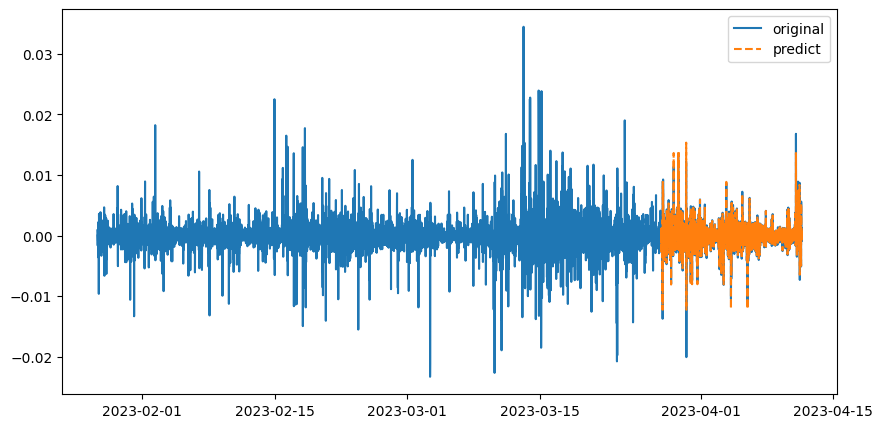

In [52]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

y_ = np.concatenate([np.array([None for i in range(len(y_train)+len(y_validation))]) , y_pred])
y_ = pd.DataFrame(y_, index=x.index)

plt.figure(figsize=(10,5))
plt.plot(y, label='original')
plt.plot(y_, '--', label='predict')
plt.legend()